# [ERG-190C] Homework 11: Support Vector Machines

---

This homework will use support vector machines to classify CalEnviroScreen data. 

### Homework Objectives
1. Learn about the intuition behind the Perceptron Algorithm and Maximal Margin Classifiers
2. Learn about the intuition behind support vector machines: classifiers, features and more
3. Learn to apply Support Vector Machines using Real-Life Data, in the form of CalEnviroScreen data
4. Learn about making our own classifiers for Support Vector Machines

The **main** take-away from this homework is a strong intuition of how SVM works, as well as the ability to tweak SVM in dealing with other real-life data that do not always conform to "nice" kernels. 

We will take gradual steps in this homework, starting from recalling key information from lectures and textbook, to creating our own classifiers. 

### Table of Contents

[CalEnviroScreen Data](#data)<br>
1 - [Section 1 - Perceptron Algorithm and MMC](#section 1)<br>
2 - [Section 2 - SVM Intuition](#section 2)<br>
3 - [Section 3 - Using SVM to Classify CalEnviroScreen Data](#section 3) <br>
4 - [Section 4 - Custom Margins](#section 4)<br>

**Dependencies:**

In [1]:
# Import Packages
import numpy as np
import pandas as pd
from matplotlib import style
from matplotlib import pyplot as plt

# Import Samples Generator
from sklearn.datasets.samples_generator import make_circles
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

# Color Scheme for SVM!
colormap = np.array(['blue', 'gold']) # Go bears!

# Allows us to plot SVC decision functions
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC
    
    Variables: 
        model: classifier
    
    Usage:
    >>> from sklearn.svm import SVC
    >>> clf = SVC(kernel='linear')
    >>> clf.fit(X, y)
    >>> plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    >>> plot_svc_decision_function(clf) # Draw the decision boundary
    >>> plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');
    """
    # You don't have to understand this block of code!
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

---

## CalEnviroScreen Dataset <a id='data'></a>
Carrying on from the previous homework, we will be using the CalEnviroScreen dataset. CalEnviroScreen 3.0 is a comprehensive documentation of the environmental and the demographic conditions of each county in California. Following the collection of these data, CalEnviroScreen 3.0 gives a CES Score, which is the Pollution Score multiplied by Population Characteristics Score. 

In this homework, while the CES Score gives us a good indication of the environmental conditions of counties (although CalEnviroScreen does not tell us how they calculated the score!), we are interested in seeing how different demographic conditions affect environmental conditions. 

Please note that the Excel file can be downloaded from [here](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30). However, for this homework, the Excel file has already been compiled into CSV files using the [xlsx2csv](https://github.com/dilshod/xlsx2csv) library. If you are interested in how this was done, take a look at the [xlsx2csv](https://github.com/dilshod/xlsx2csv) Github repository as linked!

---
## Section 1: Perceptron Algorithm and Maximal Margin Classification  <a id='section 1'></a>

#### Reminder on the Perceptron Algorithm:

The perceptron algorithm is a simpler model of the SVM algorithm. It assumes that all the data points are __linearly separable__ and is thus unsuitable for use in many datasets. Given a training dataset of $n$ points, $D = \{(x_i, y_i)\}_{i = 1}^{n}$, where $x_i \in R^d$ and $y_i \in \{-1 , +1\}$, the perceptron algorithm finds a $d - 1$ hyperplane that perfectly seperates $+1$ and $-1$. 

**Question 1.1:**
In this question, we are going to use `make_blobs` and `make_circles` extensively. These are sample generators made by `scikit-learn` package, which will allow us to randomly generate blobs and circles! 

The following cell is an example of how we might call `make_blobs`.

*Note that `make_blobs` sometimes does not work as intended. Re-run the cell if you do not see a clear distinction between the two blobs*

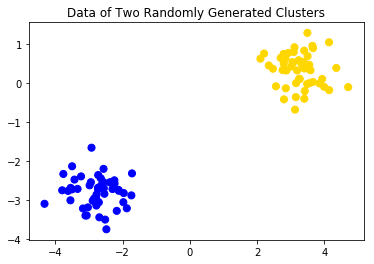

In [3]:
# RE-RUN ME IF BLOBS ARE NOT VISIBLY SEPARABLE

# Generating blobs of data with 2 centers
X, y = make_blobs(n_samples=100, centers=2, cluster_std=0.50, center_box=(-4, 4))

# Plotting the blobs of data
plt.title("Data of Two Randomly Generated Clusters")
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plt.show()

There are a lot of hyperplanes that can separate these two clusters of data. Give 3 possible examples in the code below by calculating by hand, where first item should be the gradient and second item should be the y-intercept. In other words, `first/second/third = (gradient, y-intercept)`: 

In [ ]:
first = (...)
second = (...)
third = (...)

Run the following cell to double-check that your answers are right and reasonable

In [ ]:
# Plotting 
xfit = np.linspace(-4, 4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

for m, c in [first, second, third]:
    plt.plot(xfit, m * xfit + c, '-k')

plt.title("Two Randomly Generated Clusters and Hyperplanes Separating Them")
plt.xlim(-4, 4)
plt.show()

<b> Question 1.2: </b> There are multiple answers (we definitely know there is 3!) to Question 1.1. Explain why. 

Answer: ...

__Question 1.3:__ Because of issues as explored in Questions 1.2 and 1.3, in practical usage, we default to using maximal margin classification or __hard-margin SVM__. What makes hard-margin SVMs different to the perceptron algorithm that we have been exposed to so far? 

Answer: ...

#### Question 1.4: 

We are now going to examine how to code Perceptrons, especially since this process is very similar to that of coding SVMs (which we will see in later sections). First, we import the necessary library: 

In [4]:
from sklearn.linear_model import Perceptron

Next, we create our artificial dataset, and it has been hard-coded below. Later, we will use `scikit-learn`'s `samples_generator` to create our datasets. But, for now, let's try to develop a better understanding of the kind of data that we need to classify information

In [5]:
x = np.array([
[2, 1, 2, 5, 8, 2, 3, 6, 1, 2, 5, 5, 3, 5, 6],
[2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 7, 3, 7, 3]
])

y = np.array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1])

**Question 1.4.1:** What is the purpose of `x` and `y` in the above block of code? Following the question, what will the coordinate $(5, 5)$ be labelled as?

Answer: ...

Now that we have developed an understanding of what our data is, let's graph the data out, to gain a even better understanding of the data!

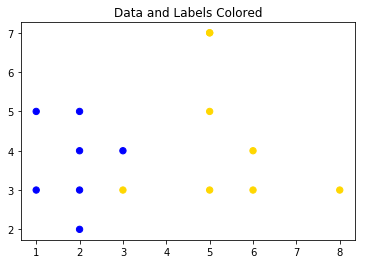

In [6]:
plt.title("Data and Labels Colored")
plt.scatter(x[0], x[1], c=colormap[y], s=40)
plt.show()

**Question 1.4.2:** Based on the graph, is this dataset linearly separable, or not? If not, name the possible coordinates that makes the graph not linearly separable. 

Answer: ...

Now, we are going to try coding out for ourselves the Perceptron algorithm, using a modified dataset, as in the following block of code: 

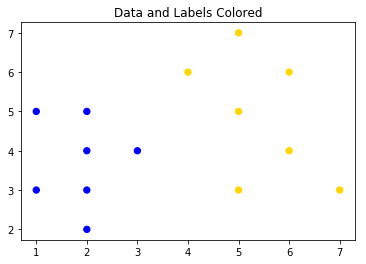

In [7]:
data = np.array([
[2, 1, 2, 5, 7, 2, 3, 6, 1, 2, 5, 4, 6, 5],
[2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 7]
])

label = np.array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])
plt.title("Data and Labels Colored")
plt.scatter(data[0], data[1], c=colormap[label], s=40)
plt.show()

**Question 1.4.3:** In the following block, set up our classifier, using `Perceptron`. Look at the following [link](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) for more information on setting up a classifier. We want the model to have the following parameters:
1. `n_iter` = 100
2. `verbose` = 0
3. `eta` = 0.002 

In [ ]:
classifier = ...

**Question 1.4.4:** In the following block, we are going to use the Perceptron classifier that we have set-up and fit the data in. Again, please refer to the following [link](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) for more information on using the classifier. 

Please note that we are going to rotate our `data` by 180 degrees, to allow fitting of data (`data` was made with graphing in mind, not classifying)

*Hint: `.fit` takes in two parameters, data and labels*

In [ ]:
# rotate the data 180 degrees
data90 = np.rot90(data)
data90 = np.rot90(data90)
data90 = np.rot90(data90)

# YOUR CODE HERE - Create the Model
...

Finally, let's run the following cell to see what kind of decision boundary we have come up with! If it does not look right / separates two datasets completely, there must have been some mistake above. Look carefully at the parameters for the Perceptron classifier. 

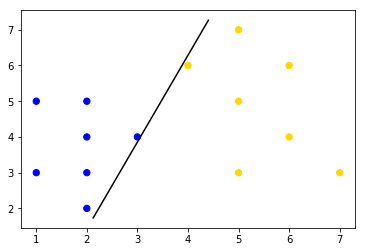

In [10]:
# Plot the original data
plt.scatter(data[0], data[1], c=colormap[label], s=40)

# Calc the hyperplane (decision boundary)
ymin, ymax = plt.ylim()
w = classifier.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(ymin, ymax)
yy = a * xx - (classifier.intercept_[0]) / w[1]

# Plot the line
plt.plot(yy,xx, 'k-')
plt.show()

**Question 1.4.5:** Name one coordinate, when added, will **NOT** change the decision boundary and name one coordinate, when added, **WILL** change the decision boundary.

Answer: ...

---
## Section 2: SVM Intuition <a id='section 2'></a>

### Question 2.1: Word Problems!
Before we start classifying CalEnviroScreen Dataset, let's recap about the intuitions behind using Support Vector Machines. 

<img src="img/svd.png" width="400">

This is an example of an artificially created data-set to be classified, where red $+$ data points and green $O$ data points are to be classified frome each other. In the following questions, assume the following: 
1. Training data comes from error-prone sensors, so we should not trust any specific points too much
2. We are training our SVM using a __quadratic__ kernel. The slack penalty $C$ will determine the location of the separating hyperplane.

Answer the following questions with a True / False and a one line justification.

__Question 2.1.1__: Given the potential decision boundaries below, which one will have a large slack penalty $C$ (i.e. $C \to \infty$) and which one will have a small slack penalty $C$ (i.e. $C \to 0$)?
<img src="img/svd2.png" width="400">

Answer: ...

<br>
__Question 2.1.2__: In this particular dataset, would it be more advantageous to use a small slack penalty $C$ or a large slack penalty $C$?

Answer: ...

<br>
__Question 2.1.3__: Name one coordinate that will __not change__ the decision boundary learned for
very large values of C. Justify your answer.

Answer: ...

<br>
__Question 2.1.4__: Name one coordinate that __will__ change the decision boundary learned for very large values of $C$. Justify your answer.

Answer: ...

<br>
**Question 2.1.5:** In general, would we have more support vectors with higher $C$ or lower $C$. Explain.

Answer: ...

### Question 2.2: Intuition from Pictures & Learning to Use `Scikit-learn`'s `svm` Models
Before we begin the question formally, run the following cell to unlock the ability to run SVM using `scikit-learn`. We will also call the different libraries that we will be using in this question, namely `samples_generator`.

In this question, we are going to use `make_blobs` and `make_circles` extensively. These are sample generators made by `scikit-learn` package, which will allow us to randomly generate blobs and circles! 

The following cell is an example of how we might call `make_blobs`, and feel free to play around with the parameters! Keep this in mind as you will later be asked to call `make_circles`. 

*Note that `make_blobs` sometimes does not work as intended. Re-run the cell if you do not see a clear distinction between the two blobs*

In [ ]:
# Generating blobs of data with 2 centers
X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.60, center_box=(-4, 4))

# Plotting the blobs of data
plt.title("Data of Two Randomly Generated Clusters")
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plt.xlim(-4, 4)
plt.show()

From *Question 1.1*, we saw that there are many hyperplanes that could separate these data. We do not want these issues arising, so for linearly separable data, we have previously explored using Maximum Margin Classifiers, or hard-margin SVMs. Let's now actually try to use support vector machines to classify our data. 

**Question 2.2.1:** Make the Support Vector Machine Classifier in the following cell, with the following parameters: 
1. `kernel` should be linear
2. Set the slack variable `C` to be a large number, like `1E10`

*Hint: Use `SVC` to create your model and refer to this [link](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for more information*

In [ ]:
clf = ... # clf is short for classifier

**Question 2.2.2:** Why did we have to set the slack variable $C$ to be a large number in Question *2.2.1*? 

Answer: ...

**Question 2.2.3:** Having created the classifier as `clf`, we can start training our data. In the following cell, train our data (of randomly generated blobs) using the classifier we have just created. 

*Hints: data for blobs are `X` and labels are `y` and the function `fit` may come in handy*

In [ ]:
...

Now, let's have a look at what we have made by running the following cell! If it does not look right, look back at your `clf` and training codes!

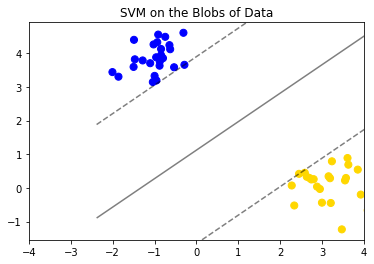

In [16]:
# Graphing SVM and Data
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)

plt.title("SVM on the Blobs of Data")
plt.xlim(-4, 4)
plt.show()

So far, we have only really dealt with linearly separable data. What happens if the data is not linearly separable? Let's examine these cases in the following questions. 

**Question 2.2.4:** Just as we have created our dataset for blobs of data, make a new dataset for circles below. 

*Hint: Refer to the code above and the function `make_circles` may come in handy*

In [ ]:
X, y = ...

**Question 2.2.5**: Train this new dataset using a linear kernel. Adjust the slack variable `C` accordingly. The code will graph the results out immediately for you.

*Hint: If training takes too long, your slack variable is probably too high!*

In [ ]:
clf = ...
...

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM (Linear) on Circles of Data")
plt.show()

We cannot really see a hyper-plane that distinguishes these two data points, so let's move up a dimension and see if we can find a hyperplane separating these two clusters of data

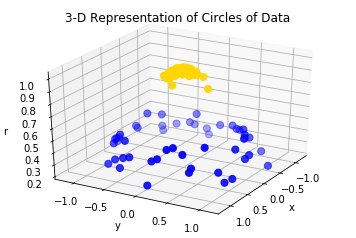

In [22]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], 
             X[:, 1], 
             np.exp(-(X ** 2).sum(1)), 
             c=colormap[y], 
             s=50)

ax.view_init(elev=30, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')
    
plt.title("3-D Representation of Circles of Data")
plt.show()

**Question 2.2.6:** Yay! We have found a hyper-plane. These data points are definitely not linearly separable. But, we can see a clear distinction between the two classes of data. What kernel might we use to run SVM on this data-set? 

Answer: ...

**Question 2.2.7:** Follow the processes we have taken to firstly create a classifier model and then train the data,  to use your answer to *Question 2.2.6* to generate and train a classifier for this particular dataset. Unlike previous quesions, there will be no starting code, but feel free to refer to your answers to previous questions to gain insight!

*Hint: You may need to specify slack variables to generate a good answer*

In [ ]:
# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM on Circles of Data")
plt.show()

---
## Section 3: Using SVM to Classify CalEnviroScreen Data <a id='section 3'></a>

<br>
Now that we have a solid understanding of how SVM works, let's begin applying our classroom knowledge on real-life data. 

In [8]:
env = pd.read_csv('data/ces3results_environment.csv')
demog = pd.read_csv('data/ces3results_demographics.csv')

Second, let's have a look at what each of these data entails: 

In [7]:
env.head()

,Census Tract,Total Population,California County,ZIP,Nearby City (to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.09,100.00,95-100% (highest scores),...,77.51,76.3,97.12,17.6,91.72,26.0,79.40,92.12,9.55,99.70
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.68,99.99,95-100% (highest scores),...,96.25,72.5,94.63,12.3,71.82,34.1,93.75,87.44,9.07,98.11
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.97,99.97,95-100% (highest scores),...,78.39,86.8,99.56,16.1,87.98,40.1,97.85,94.58,9.81,99.99
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.49,99.96,95-100% (highest scores),...,75.14,61.3,85.57,19.6,94.97,21.1,63.54,86.70,8.99,97.72
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.03,99.95,95-100% (highest scores),...,73.72,66.4,90.23,18.6,93.65,28.1,83.98,80.08,8.30,92.76


In [27]:
demog.head()

,Census Tract,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,Total Population,California County,Children < 10 (%),Pop 11-64 years (%),Elderly > 65 (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other (%)
0,6019001100,94.09,100.00,95-100% (highest scores),3174,Fresno,18.8,73.6,7.6,65.3,4.2,24.6,0.5,3.5,1.8
1,6071001600,90.68,99.99,95-100% (highest scores),6133,San Bernardino,19.7,76.1,4.2,91.1,5.8,0.7,0.3,1.4,0.7
2,6019000200,85.97,99.97,95-100% (highest scores),3167,Fresno,21.5,72.5,6.0,63.6,5.3,18.9,0.6,9.8,1.8
3,6077000801,82.49,99.96,95-100% (highest scores),6692,San Joaquin,18.7,74.5,6.8,57.4,6.0,12.5,0.3,20.9,2.8
4,6019001500,82.03,99.95,95-100% (highest scores),2206,Fresno,14.8,72.1,13.1,71.8,21.4,1.2,0.5,4.5,0.6


**Question 3.1:** These datasets are huge and we want to limit our classification for the purposes of this homework. Use `pandas` to select data if they are `95-100% (highest scores)` or `1-5% (lowest scores)` in `CES 3.0 \nPercentile Range` for the `env` dataframe. 

*Hint: Use `.loc` and `.isin` functions to select rows from Dataframe based on conditions*

In [ ]:
new_env = ...

**Question 3.2:** Remember that CES 3.0 scores are generated from demographic and environmental data. From `env` dataframe, create test data and our label data. 

Let `X` be the test data consisting of `Census Tract`, `Unemployment` and `PM2.5` and `y` be the label data consisting of `Census Tract` and `CES 3.0 \nPercentile Range`. 

*Note: `Census Tract` is not necessary but we include it for later purposes. *

In [ ]:
X = new_env...
y = new_env...

**Question 3.3:** Uh-oh, some of the data in `X` contain Null or `np.nan` values. Yikes! We need to fix this issue. In the cell below, change `X` by dropping any `np.nan` values

*Hint: Use `.dropna()` function*

In [ ]:
X = ...

**Question 3.4:** Now, our Null values our gone. But, we have come to another issue - the number of rows in `X` and `y` are different (we have dropped rows in `X`!). To fix this issue, let's merge `X` and `y` into a single dataframe on `Census Tract`. 

In [ ]:
df = ...

**Question 3.5:** We previously included `Census Tract` data for the purpose of merging `X` and `y`. We do not need this data anymore for the classification. Select `X` and `y` from `df` such that we only have `PM2.5`, `Unemployment` data in `X` and only `CES 3.0 \nPercentile Range` in `y`. 

In [ ]:
X = ...
y = ...

**Question 3.6:** Now let's split `X` and `y` into four different sets: 
1. `X` Training Data: 80% of Environment data
2. `X` Testing Data: 20% of Environment data
3. `y` Training Data: 80% of Demographics data
4. `y` Testing Data: 20% of Demographics Data

*Hint: `train_test_split` function will come in handy!*

In [ ]:
X_train, X_test = ... 
Y_train, Y_test = ...

**Question 3.7:** Whew, that was a lot of clean-up of data. Let's start classifying information now. Below, like *Question 2.2.7*, make a SVM classifier with a linear kernel (choose $C$ of your choice! Remember, if it takes too long, it is probably too high) and train the data. 

*Hint: If you get the error,* 

>`DataConversionWarning`: A column-vector ?? was passed when a `1d` array was expected. Please change the shape of ?? to (n_samples, ), for example using `ravel()`

*use ??.values.ravel() to override this issue*

In [ ]:
svclassifier = ...
...

**Question 3.8:** Use the classifier to predict the outcome of our `X_test`. 

In [ ]:
y_pred = ...

Congratulations! You have completed training a data-set. Run the box below to see if you are getting a reasonable percentage of correct matches (~90%) 

In [36]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[71  1]
 [ 5 80]]
                          precision    recall  f1-score   support

    1-5% (lowest scores)       0.93      0.99      0.96        72
95-100% (highest scores)       0.99      0.94      0.96        85

             avg / total       0.96      0.96      0.96       157



---
## Section 4: Custom Kernels <a id='section 4'></a>

In this section, we will learn to create our own kernels for SVM. So far, we have relied predominantly on: 
1. Our intuition of how different kernels look and behave
2. Scikit-learn's implementation of SVM and kernels. 

But, suppose we are given a scenario where we have to come up with something completely **novel**. Therefore, the goal of this section is to reduce our reliance on the abstractions provided by Scikit-learn, so that we may move forward, even in cases where we have to create something new. Because the implementation of SVM itself is very difficult to emulate in a homework set, we will resort to defining our own kernels. 


First, to utilize support vector machines, we import SVM from Scikit-learn and Numpy.

In [37]:
from sklearn import svm
import numpy as np 

**Question 4.1:** Define linear kernel below. 

*Hint: Linear kernel has the formula: $<x, y>$*

In [ ]:
def linear_kernel(x, y): 
    """ 
    This is the function for linear margin, which is 
    defined as a dot product between vectors:
    
    linear_margin(x, y) = <x, y> 
    """
    # YOUR CODE HERE
    return 

**Question 4.2:** A key component of data analysis is spotchecking. Let's test that our new, not-reliant-on-scikit-learn kernel truly functions! Fill in the missing code boxes below (in doubt, refer to [Section 2](#section 2)) and run it to test if our linear kernel functions the same way (or better!) than scikit-learn's implementation.

*Hint: Specify kernel to be `linear_kernel` in SVC*

We will begin with making our own blob of data:

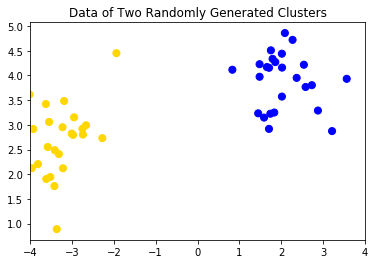

In [41]:
# Generating blobs of data with 2 centers
X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.60, center_box=(-4, 4))

# Plotting the blobs of data
plt.title("Data of Two Randomly Generated Clusters")
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plt.xlim(-4, 4)
plt.show()

In [ ]:
clf = ...
...

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf, plot_support=False)
plt.title("SVM (Linear) on Circles of Data")
plt.show()

**Question 4.3:** Linear kernels are interesting and very intuitive, but can we make kernels for something more? Define a radial-basis function. 

*Hints:* 

1. 
$$K(x, y) = e^{-g ||x - y||^2}$$

2. In the code below, ``dists_sq`` refers to the distance between x and y, squared

In [ ]:
def radial_kernel(x, y, gamma):
    """
    This is the function for Radial Basis Function kernel, defined as:
        K(x, y) = e^(-gamma * ||x - y||^2)
    """
    # YOUR CODE HERE
    dists_sq = ...
    return ...

**Question 4.4**: So far, we have created kernels for linear and the radial functions. Let's try to create a kernel for something we have not encountered yet. The following [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.214.3092&rep=rep1&type=pdf), *A Least Square Kernel Machine with Box Constraints* by Jayanta Basak of IBM India Research Lab, presents us with some new kernels. 

In this question, we will look specifically at the *Cauchy kernel* that Basak describes in the paper. 

The Cauchy Kernel is described as:

$$K(x, y) = \frac{1}{1 + \frac{||x + y||^2}{\sigma^2}}$$

Implement the Cauchy Kernel below.

In [ ]:
def cauchy_kernel(x, y, sigma):
    """
    This is the function for Cauchy kernel, defined as:
        K(x, y) = 1 / (1 + ||x - y||^2 / sigma ^ 2)
                
    as defined in:
    "A least square kernel machine with box constraints"
    Jayanta Basak, International Conference on Pattern Recognition 2008
    """
    # YOUR CODE HERE
    dists_sq = ...
    return ...

---
## Submission

Congrats, you finished the final homework!

Before you submit, click **Kernel** --> **Restart & Clear Output**. Then, click **Cell** --> **Run All**. Then, go to the toolbar and click **File** -> **Download as** -> **.html** and submit the file through bCourses.

---

## Bibliography

Carnegie Mellon University's Machine Learning Course (10 - 701) - Images on Question 2 - http://www.cs.cmu.edu/~ninamf/courses/601sp15/lectures.shtml

Jayanta Basak, *A Least Square Kernel Machine with Box Constraints* - Inspiration and Formula for Question 4.4 - http://www.jprr.org/index.php/jprr/article/viewfile/181/57

Jake VanderPlas - Function for Drawing SVC Decision Boundaries - *Python Data Science Handbook*

---
Notebook developed by: Beom Jin Lee (Brian)

Data Science Modules: http://data.berkeley.edu/education/modules
